In [1]:
import os
import importlib
import numpy as np
import tensorflow as tf

import texar.tf as tx

from texar.tf.modules import WordEmbedder, UnidirectionalRNNEncoder, \
        MLPTransformConnector, AttentionRNNDecoder, \
        GumbelSoftmaxEmbeddingHelper, Conv1DClassifier
from texar.tf.core import get_train_op
from texar.tf.utils import collect_trainable_variables, get_batch_size

from texar.tf.data import MultiAlignedData, FeedableDataIterator

from texar import HParams

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import copy

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import csv

/home/jupyter/v1/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Importing from `texar` is deprecated. Please import from `texar.tf` instead, e.g. `import texar.tf as tx`
  app.launch_new_instance()


In [2]:
# Config
config = {
    'max_nepochs': 12, # Total number of training epochs
                 # (including pre-train and full-train)
    'pretrain_ae_nepochs': 10, # Number of pre-train epochs (training as autoencoder)
    'display': 500,  # Display the training results every N training steps.
    'display_eval': 1e10, # Display the dev results every N training steps (set to a
                    # very large value to disable it).
    'sample_path': './samples',
    'checkpoint_path': './checkpoints',
    'restore': '',   # Model snapshot to restore from

    'lambda_g': 0.1,    # Weight of the classification loss
    'lambda_z': 0.5,
    'gamma_decay': 0.5,   # Gumbel-softmax temperature anneal rate

    'change_lambda_ae': 0.,
    #'change_lambda_ae_epoch = 12,
    'change_lambda_ae_epoch': 1,

    'plot_z': True,
    'plot_max_count': 1000,

    'spam': True,
    'repetitions': True,

    'write_text': True,
    'write_labels': True,

    'manual': True,

    # Data
    'train_data' : {
        'batch_size': 64,
        # "max_dataset_size": 256,
        #'seed': 123,
        'datasets': [
            {
                'files': './data/yelp/sentiment.train.text',
                'vocab_file': './data/yelp/vocab',
                'data_name': ''
            },
            {
                'files': './data/yelp/sentiment.train.labels',
                'data_type': 'int',
                'data_name': 'labels'
            }
        ],
        'name': 'train'
    }
}

config['test_data'] = copy.deepcopy(config['train_data'])
config['test_data']['datasets'][0]['files'] = './data/yelp/sentiment.test.text'
config['test_data']['datasets'][1]['files'] = './data/yelp/sentiment.test.labels'

config['val_data'] = copy.deepcopy(config['train_data'])
config['val_data']['datasets'][0]['files'] = './data/yelp/sentiment.dev.text'
config['val_data']['datasets'][1]['files'] = './data/yelp/sentiment.dev.labels'
        
if config['manual']:
    config['manual_data'] = copy.deepcopy(config['train_data'])
    config['manual_data']['datasets'][0]['files'] = './data/yelp/sentiment.manual.text'
    config['manual_data']['datasets'][1]['files'] = './data/yelp/sentiment.manual.labels'
    
model_dict = {
    'dim_c': 200,
    'dim_z': 500,
    'num_classes': 2,
    'embedder': {
        'dim': 100,
    },
    'encoder': {
        'rnn_cell': {
            'type': 'GRUCell',
            'kwargs': {
                'num_units': 700
            },
            'dropout': {
                'input_keep_prob': 0.5
            }
        }
    },
    'decoder': {
        'rnn_cell': {
            'type': 'GRUCell',
            'kwargs': {
                'num_units': 700,
            },
            'dropout': {
                'input_keep_prob': 0.5,
                'output_keep_prob': 0.5
            },
        },
        'attention': {
            'type': 'BahdanauAttention',
            'kwargs': {
                'num_units': 700,
            },
            'attention_layer_size': 700,
        },
        'max_decoding_length_train': 21,
        'max_decoding_length_infer': 20,
    },
    'classifier': {
        'kernel_size': [3, 4, 5],
        'filters': 128,
        'other_conv_kwargs': {'padding': 'same'},
        'dropout_conv': [1],
        'dropout_rate': 0.5,
        'num_dense_layers': 0,
        'num_classes': 1
    },
    'opt': {
        'optimizer': {
            'type':  'AdamOptimizer',
            'kwargs': {
                'learning_rate': 5e-4,
            },
        },
    },
    'z_classifier_l1': {
        'activation_fn': 'sigmoid'
    },
    'z_classifier_l2': {
        'activation_fn': 'sigmoid'
    }
}

In [3]:
class CtrlGenModel(object):

    def __init__(self, inputs, vocab, gamma, lambda_g, lambda_z, lambda_ae, hparams=None):
        self._hparams = HParams(hparams, None)
        self._build_model(inputs, vocab, gamma, lambda_g, lambda_z, lambda_ae)


    def _build_model(self, inputs, vocab, gamma, lambda_g, lambda_z, lambda_ae):

        embedder = WordEmbedder(
            vocab_size=vocab.size,
            hparams=self._hparams.embedder)

        encoder = UnidirectionalRNNEncoder(hparams=self._hparams.encoder)

        enc_text_ids = inputs['text_ids'][:, 1:]
        enc_outputs, final_state = encoder(embedder(enc_text_ids),
                                           sequence_length=inputs['length']-1)

        z = final_state[:, self._hparams.dim_c:]

        # -------------------- Z CLASSIFIER ---------------------

        n_classes = self._hparams.num_classes
        z_classifier_l1 = MLPTransformConnector(256, hparams=self._hparams.z_classifier_l1)
        z_classifier_l2 = MLPTransformConnector(64, hparams=self._hparams.z_classifier_l2)
        z_classifier_out = MLPTransformConnector(n_classes if n_classes > 2 else 1)

        z_logits = z_classifier_l1(z)
        z_logits = z_classifier_l2(z_logits)
        z_logits = z_classifier_out(z_logits)
        z_pred = tf.greater(z_logits, 0)
        z_logits = tf.reshape(z_logits, [-1])

        z_pred = tf.to_int64(tf.reshape(z_pred, [-1]))

        loss_z_clas = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.to_float(inputs['labels']), logits=z_logits)
        loss_z_clas = tf.reduce_mean(loss_z_clas)

        accu_z_clas = tx.evals.accuracy(labels=inputs['labels'], preds=z_pred)

        # -------------------________________---------------------


        label_connector = MLPTransformConnector(self._hparams.dim_c)

        labels = tf.to_float(tf.reshape(inputs['labels'], [-1, 1]))

        c = label_connector(labels)
        c_ = label_connector(1 - labels)

        h = tf.concat([c, z], 1)
        h_ = tf.concat([c_, z], 1)

        # Teacher-force decoding and the auto-encoding loss for G

        decoder = AttentionRNNDecoder(
            memory=enc_outputs,
            memory_sequence_length=inputs['length']-1,
            cell_input_fn=lambda inputs, attention: inputs,
            vocab_size=vocab.size,
            hparams=self._hparams.decoder)

        connector = MLPTransformConnector(decoder.state_size)

        g_outputs, _, _ = decoder(
            initial_state=connector(h), inputs=inputs['text_ids'],
            embedding=embedder, sequence_length=inputs['length']-1)

        loss_g_ae = tx.losses.sequence_sparse_softmax_cross_entropy(
            labels=inputs['text_ids'][:, 1:],
            logits=g_outputs.logits,
            sequence_length=inputs['length']-1,
            average_across_timesteps=True,
            sum_over_timesteps=False)

        # Gumbel-softmax decoding, used in training

        start_tokens = tf.ones_like(inputs['labels']) * vocab.bos_token_id

        end_token = vocab.eos_token_id

        gumbel_helper = GumbelSoftmaxEmbeddingHelper(
            embedder.embedding, start_tokens, end_token, gamma)

        soft_outputs_, _, soft_length_, = decoder(
            helper=gumbel_helper, initial_state=connector(h_))

        # Greedy decoding, used in eval

        outputs_, _, length_ = decoder(
            decoding_strategy='infer_greedy', initial_state=connector(h_),
            embedding=embedder, start_tokens=start_tokens, end_token=end_token)

        # Creates classifier

        classifier = Conv1DClassifier(hparams=self._hparams.classifier)

        clas_embedder = WordEmbedder(vocab_size=vocab.size,
                                     hparams=self._hparams.embedder)

        # Classification loss for the classifier

        clas_logits, clas_preds = classifier(
            inputs=clas_embedder(ids=inputs['text_ids'][:, 1:]),
            sequence_length=inputs['length']-1)

        loss_d_clas = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.to_float(inputs['labels']), logits=clas_logits)

        loss_d_clas = tf.reduce_mean(loss_d_clas)

        accu_d = tx.evals.accuracy(labels=inputs['labels'], preds=clas_preds)

        # Classification loss for the generator, based on soft samples

        soft_logits, soft_preds = classifier(
            inputs=clas_embedder(soft_ids=soft_outputs_.sample_id),
            sequence_length=soft_length_)

        loss_g_clas = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.to_float(1-inputs['labels']), logits=soft_logits)

        loss_g_clas = tf.reduce_mean(loss_g_clas)

        # Accuracy on soft samples, for training progress monitoring

        accu_g = tx.evals.accuracy(labels=1-inputs['labels'], preds=soft_preds)

        # Accuracy on greedy-decoded samples, for training progress monitoring

        _, gdy_preds = classifier(
            inputs=clas_embedder(ids=outputs_.sample_id),
            sequence_length=length_)

        accu_g_gdy = tx.evals.accuracy(
            labels=1-inputs['labels'], preds=gdy_preds)

        # Aggregates losses

        loss_g = lambda_ae * loss_g_ae + \
                 lambda_g * loss_g_clas - lambda_z * loss_z_clas
        loss_d = loss_d_clas
        loss_z = loss_z_clas

        # Creates optimizers

        g_vars = collect_trainable_variables(
            [embedder, encoder, label_connector, connector, decoder])
        d_vars = collect_trainable_variables([clas_embedder, classifier])
        z_vars = collect_trainable_variables([z_classifier_l1, z_classifier_l2, z_classifier_out])

        train_op_g = get_train_op(
            loss_g, g_vars, hparams=self._hparams.opt)
        train_op_g_ae = get_train_op(
            loss_g_ae, g_vars, hparams=self._hparams.opt)
        train_op_d = get_train_op(
            loss_d, d_vars, hparams=self._hparams.opt)
        train_op_z = get_train_op(
            loss_z, z_vars, hparams=self._hparams.opt
        )

        # Interface tensors
        self.losses = {
            "loss_g": loss_g,
            "loss_g_ae": loss_g_ae,
            "loss_g_clas": loss_g_clas,
            "loss_d": loss_d_clas,
            "loss_z_clas": loss_z_clas,
        }
        self.metrics = {
            "accu_d": accu_d,
            "accu_g": accu_g,
            "accu_g_gdy": accu_g_gdy,
            "accu_z_clas": accu_z_clas
        }
        self.train_ops = {
            "train_op_g": train_op_g,
            "train_op_g_ae": train_op_g_ae,
            "train_op_d": train_op_d,
            "train_op_z": train_op_z
        }
        self.samples = {
            "original": inputs['text_ids'][:, 1:],
            "transferred": outputs_.sample_id,
            "z_vector": z,
            "labels_source": inputs['labels'],
            "labels_target": 1 - inputs['labels'],
            "labels_predicted": gdy_preds
        }

        self.fetches_train_g = {
            "loss_g": self.train_ops["train_op_g"],
            "loss_g_ae": self.losses["loss_g_ae"],
            "loss_g_clas": self.losses["loss_g_clas"],
            "accu_g": self.metrics["accu_g"],
            "accu_g_gdy": self.metrics["accu_g_gdy"],
            "accu_z_clas": self.metrics["accu_z_clas"]
        }

        self.fetches_train_z = {
            "loss_z": self.train_ops["train_op_z"],
            "accu_z": self.metrics["accu_z_clas"]
        }

        self.fetches_train_d = {
            "loss_d": self.train_ops["train_op_d"],
            "accu_d": self.metrics["accu_d"]
        }
        fetches_eval = {"batch_size": get_batch_size(inputs['text_ids'])}
        fetches_eval.update(self.losses)
        fetches_eval.update(self.metrics)
        fetches_eval.update(self.samples)
        self.fetches_eval = fetches_eval

In [4]:
def train_model():
    train_data = MultiAlignedData(config['train_data'])
    val_data = MultiAlignedData(config['val_data'])
    test_data = MultiAlignedData(config['test_data'])
    if config['manual']:
        manual_data = MultiAlignedData(config['manual_data'])
    
    vocab = train_data.vocab(0)

    # Each training batch is used twice: once for updating the generator and
    # once for updating the discriminator. Feedable data iterator is used for
    # such case.
    if config['manual']:
        iterator = FeedableDataIterator(
            {'train_g': train_data, 'train_d': train_data, 'train_z': train_data,
              'val': val_data, 'test': test_data, 'manual': manual_data})
    else:
        iterator = FeedableDataIterator(
            {'train_g': train_data, 'train_d': train_data, 'train_z': train_data,
              'val': val_data, 'test': test_data})
    batch = iterator.get_next()

    # Model
    gamma = tf.placeholder(dtype=tf.float32, shape=[], name='gamma')
    lambda_g = tf.placeholder(dtype=tf.float32, shape=[], name='lambda_g')
    lambda_z = tf.placeholder(dtype=tf.float32, shape=[], name='lambda_z')
    lambda_ae = tf.placeholder(dtype=tf.float32, shape=[], name='lambda_ae')
    model = CtrlGenModel(batch, vocab, gamma, lambda_g, lambda_z, lambda_ae, model_dict)

    def _train_epoch(sess, gamma_, lambda_g_, lambda_z_, lambda_ae_, epoch, verbose=True):
        avg_meters_d = tx.utils.AverageRecorder(size=10)
        avg_meters_g = tx.utils.AverageRecorder(size=10)
        avg_meters_z = tx.utils.AverageRecorder(size=10)

        step = 0
        while True:
            try:
                step += 1
                feed_dict = {
                    iterator.handle: iterator.get_handle(sess, 'train_d'),
                    gamma: gamma_,
                    lambda_g: lambda_g_,
                    lambda_z: lambda_z_,
                    lambda_ae: lambda_ae_
                }

                vals_d = sess.run(model.fetches_train_d, feed_dict=feed_dict)
                avg_meters_d.add(vals_d)

                feed_dict = {
                    iterator.handle: iterator.get_handle(sess, 'train_g'),
                    gamma: gamma_,
                    lambda_g: lambda_g_,
                    lambda_z: lambda_z_,
                    lambda_ae: lambda_ae_
                }
                vals_g = sess.run(model.fetches_train_g, feed_dict=feed_dict)
                avg_meters_g.add(vals_g)

                feed_dict = {
                    iterator.handle: iterator.get_handle(sess, 'train_z'),
                    gamma: gamma_,
                    lambda_g: lambda_g_,
                    lambda_z: lambda_z_,
                    lambda_ae: lambda_ae_
                }
                vals_z = sess.run(model.fetches_train_z, feed_dict=feed_dict)
                avg_meters_z.add(vals_z)


                if verbose and (step == 1 or step % config['display'] == 0):
                    print('epoch: {}, step: {}, {}'.format(epoch, step, avg_meters_d.to_str(4)))
                    print('epoch: {}, step: {}, {}'.format(epoch, step, avg_meters_z.to_str(4)))
                    print('epoch: {}, step: {}, {}'.format(epoch, step, avg_meters_g.to_str(4)))

                if verbose and step % config['display_eval'] == 0:
                    iterator.restart_dataset(sess, 'val')
                    _eval_epoch(sess, gamma_, lambda_g_, lambda_z_, lambda_ae_, epoch)

            except tf.errors.OutOfRangeError:
                print('epoch: {}, {}'.format(epoch, avg_meters_d.to_str(4)))
                print('epoch: {}, {}'.format(epoch, avg_meters_z.to_str(4)))
                print('epoch: {}, {}'.format(epoch, avg_meters_g.to_str(4)))
                break

    def _eval_epoch(sess, gamma_, lambda_g_, lambda_z_, lambda_ae_, epoch, val_or_test='val',
                  plot_z=False, plot_max_count=1000, spam=False, repetitions=False, write_text=True,
                  write_labels=False):
        avg_meters = tx.utils.AverageRecorder()

        if plot_z:
            z_vectors = []
            labels = []
            tsne = TSNE(n_components=2)
        while True:
            try:
                feed_dict = {
                    iterator.handle: iterator.get_handle(sess, val_or_test),
                    gamma: gamma_,
                    lambda_g: lambda_g_,
                    lambda_z: lambda_z_,
                    lambda_ae: lambda_ae_,
                    tx.context.global_mode(): tf.estimator.ModeKeys.EVAL
                }

                vals = sess.run(model.fetches_eval, feed_dict=feed_dict)

                batch_size = vals.pop('batch_size')

                # Computes BLEU
                samples = tx.utils.dict_pop(vals, list(model.samples.keys()))
                hyps = tx.utils.map_ids_to_strs(samples['transferred'], vocab)

                refs = tx.utils.map_ids_to_strs(samples['original'], vocab)
                refs = np.expand_dims(refs, axis=1)

                bleu = tx.evals.corpus_bleu_moses(refs, hyps)
                vals['bleu'] = bleu

                if spam or repetitions:
                    target_labels = samples['labels_target']
                    predicted_labels = samples['labels_predicted']

                    results = [(r, h, t, p) for r, h, t, p in zip(refs, hyps, target_labels, predicted_labels)]

                # Computes repetitions
                if repetitions:
                    count_equal_strings = 0
                    remain_samples_e = []
                    for r, h, t, p in results:
                        if r == h:
                            count_equal_strings += 1
                        else:
                            remain_samples_e.append((r, h, t, p))
                    vals['equal'] = count_equal_strings / len(hyps)

                # Computes spam
                if spam:
                    count_spam = 0
                    remain_samples_s = []
                    for r, h, t, p in results:
                        words = h.split()
                        if len(words) > 2 and words[-1] == words[-2]:
                            count_spam += 1
                        elif len(words) > 4 and words[-1] == words[-3] and words[-2] == words[-4]:
                            count_spam += 1
                        else:
                            remain_samples_s.append((r, h, t, p))
                    vals['spam'] = count_spam / len(hyps)

                if repetitions and spam:
                    remain_samples = [sample for sample in remain_samples_e if sample in remain_samples_s]
                    remain_samples = list(remain_samples)
                elif not repetitions and spam:
                    remain_samples = remain_samples_s
                elif repetitions and not spam:
                    remain_samples = remain_samples_e

                if repetitions and spam:
                    refs_remain = [r for r, h, t, p in remain_samples]
                    hyps_remain = [h for r, h, t, p in remain_samples]
                    bleu_remain = tx.evals.corpus_bleu_moses(refs_remain, hyps_remain)
                    vals['bleu_remain'] = bleu_remain

                    if len(remain_samples) != 0:
                        true_labels = 0
                        for _, _, t, p in remain_samples:
                            if t == p:
                                true_labels += 1
                        vals['acc_remain'] = true_labels / len(remain_samples)
                    else:
                        vals['acc_remain'] = 0.

                avg_meters.add(vals, weight=batch_size)

                if plot_z:
                    z_vectors += samples['z_vector'].tolist()
                    labels += samples['labels_source'].tolist()

                # Writes samples
                if write_text:
                    tx.utils.write_paired_text(
                        refs.squeeze(), hyps,
                        os.path.join(config['sample_path'], 'text_{}.{}'.format(val_or_test, epoch)),
                        append=True, mode='v')

                # Writes labels of samples
                if write_labels:
                    tx.utils.write_paired_text(
                        [str(l) for l in samples['labels_target'].tolist()],
                        [str(l) for l in samples['labels_predicted'].tolist()],
                        os.path.join(config['sample_path'], 'labels_{}.{}'.format(val_or_test, epoch)),
                        append=True, mode='v')

            except tf.errors.OutOfRangeError:
                print('epoch: {}, {}: {}'.format(
                    epoch, val_or_test, avg_meters.to_str(precision=4)))
                break

        if plot_z:
            if plot_max_count == 0:
                z_vectors = z_vectors
                labels = labels
            else:
                z_vectors = z_vectors[:plot_max_count]
                labels = labels[:plot_max_count]
            tsne_result = tsne.fit_transform(np.array(z_vectors))
            x_data = tsne_result[:, 0]
            y_data = tsne_result[:, 1]
            plt.rcParams["figure.figsize"] = 10, 10
            plt.scatter(x_data, y_data, c=np.array(labels), s=2, cmap=plt.cm.get_cmap('jet', 2))
            plt.clim(0.0, 1.0)
            if not os.path.exists('./images'):
                os.makedirs('./images')
            plt.savefig('./images/{}_{}.png'.format(val_or_test, epoch))
            plt.show()

        return avg_meters.avg()

    tf.gfile.MakeDirs(config['sample_path'])
    tf.gfile.MakeDirs(config['checkpoint_path'])

    # Runs the logics
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        sess.run(tf.tables_initializer())

        saver = tf.train.Saver(max_to_keep=None)
        if config['restore']:
            print('Restore from: {}'.format(config['restore']))
            saver.restore(sess, config['restore'])

        iterator.initialize_dataset(sess)

        gamma_ = 1.
        lambda_g_ = 0.
        lambda_z_ = 0.
        lambda_ae_ = 1.
        for epoch in range(1, config['max_nepochs']+1):
            if epoch > config['pretrain_ae_nepochs']:
                # Anneals the gumbel-softmax temperature
                gamma_ = max(0.001, gamma_ * config['gamma_decay'])
                lambda_g_ = config['lambda_g']
                lambda_z_ = config['lambda_z']
            if epoch > config['change_lambda_ae_epoch']:
                lambda_ae_ = lambda_ae_ - config['change_lambda_ae']
            print('gamma: {}, lambda_g: {}, lambda_z: {}, lambda_ae: {}'.format(
                gamma_, lambda_g_, lambda_z_, lambda_ae_))

            # Train
            iterator.restart_dataset(sess, ['train_g', 'train_d', 'train_z'])
            _train_epoch(sess, gamma_, lambda_g_, lambda_z_, lambda_ae_, epoch)

            # Val
            iterator.restart_dataset(sess, 'val')
            _eval_epoch(sess, gamma_, lambda_g_, lambda_z_, lambda_ae_, epoch, 'val', plot_z=config['plot_z'],
                        plot_max_count=config['plot_max_count'], spam=config['spam'], repetitions=config['repetitions'],
                        write_text=config['write_text'], write_labels=config['write_labels'])

            saver.save(
                sess, os.path.join(config['checkpoint_path'], 'ckpt'), epoch)

            # Test
            iterator.restart_dataset(sess, 'test')
            _eval_epoch(sess, gamma_, lambda_g_, lambda_z_, lambda_ae_, epoch, 'test', plot_z=config['plot_z'],
                        plot_max_count=config['plot_max_count'], spam=config['spam'], repetitions=config['repetitions'],
                        write_text=config['write_text'], write_labels=config['write_labels'])

            if config['manual']:
                iterator.restart_dataset(sess, 'manual')
                _eval_epoch(sess, gamma_, lambda_g_, lambda_z_, lambda_ae_, epoch, 'manual', plot_z=config['plot_z'],
                        plot_max_count=config['plot_max_count'], spam=config['spam'], repetitions=config['repetitions'],
                        write_text=config['write_text'], write_labels=config['write_labels'])

In [18]:
def print_result():
    TEXT_FILE = './samples/text_val.{}'.format(config['max_nepochs'])
    LABELS_FILE = './samples/labels_val.{}'.format(config['max_nepochs'])


    smoothing_function = SmoothingFunction()
    samples = []
    samples.append(['Input Sentence', 'Input Label', 'Generated Sentence', 'Predicted Label', 'BLEU'])
    with open(TEXT_FILE, 'r') as input_file_text:
        lines_text = input_file_text.readlines()
        with open(LABELS_FILE, 'r') as input_file_labels:
            lines_labels = input_file_labels.readlines()
            for i in range(0, len(lines_text)-1, 2):
                input_sentence = lines_text[i].strip()
                generated_sentence = lines_text[i + 1].strip()
                input_label = 1 - int(lines_labels[i])
                predicted_label = int(lines_labels[i + 1])

                words_input = input_sentence.split()
                words_generated = generated_sentence.split()
                try:
                    score = sentence_bleu([words_input], words_generated, smoothing_function=smoothing_function.method4)
                except Exception:
                    #print(input_sentence)
                    #print(generated_sentence)
                    pass

                samples.append([input_sentence, input_label, generated_sentence, predicted_label, score])
    with open('samples.csv', 'w', newline='') as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        for line in samples:
            writer.writerow(line)
    print (samples[:100])

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_ae: 1.0
epoch: 1, step: 1, loss_d: 0.6913 accu_d: 0.5312
epoch: 1, step: 1, loss_z: 0.8009 accu_z: 0.3438
epoch: 1, step: 1, loss_g: 9.1445 loss_g_ae: 9.1445 loss_g_clas: 0.6948 accu_g: 0.4219 accu_g_gdy: 0.4062 accu_z_clas: 0.4688
epoch: 1, step: 500, loss_d: 0.0959 accu_d: 0.9672
epoch: 1, step: 500, loss_z: 0.6384 accu_z: 0.6359
epoch: 1, step: 500, loss_g: 3.8663 loss_g_ae: 3.8663 loss_g_clas: 0.2393 accu_g: 0.9250 accu_g_gdy: 0.7391 accu_z_clas: 0.6078
epoch: 1, step: 1000, loss_d: 0.1059 accu_d: 0.9578
epoch: 1, step: 1000, loss_z: 0.5817 accu_z: 0.6859
epoch: 1, step: 1000, loss_g: 1.6181 loss_g_ae: 1.6181 loss_g_clas: 1.8662 accu_g: 0.4984 accu_g_gdy: 0.4797 accu_z_clas: 0.6813
epoch: 1, step: 2000, loss_d: 0.0685 accu_d: 0.9750
epoch: 1, step: 2000, loss_z: 0.4875 accu_z: 0.7656
epoch: 1, step: 2000, loss_g: 0.6890 loss_g_ae: 0.6890 loss_g_clas: 4.1219 accu_g: 0.2016 accu_g_gdy: 0.2047 accu_z_clas: 0.7672
epoch: 1, step: 2500, l

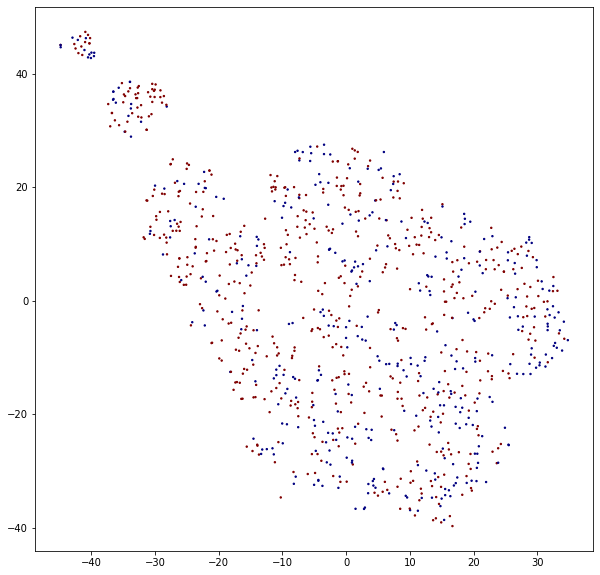

epoch: 1, test: loss_g: 0.1552 loss_g_ae: 0.1552 loss_g_clas: 6.4492 loss_d: 0.0731 loss_z_clas: 0.4879 accu_d: 0.9736 accu_g: 0.0650 accu_g_gdy: 0.0640 accu_z_clas: 0.7612 bleu: 88.9195 equal: 0.7054 spam: 0.0003 bleu_remain: 68.3817 acc_remain: 0.1648


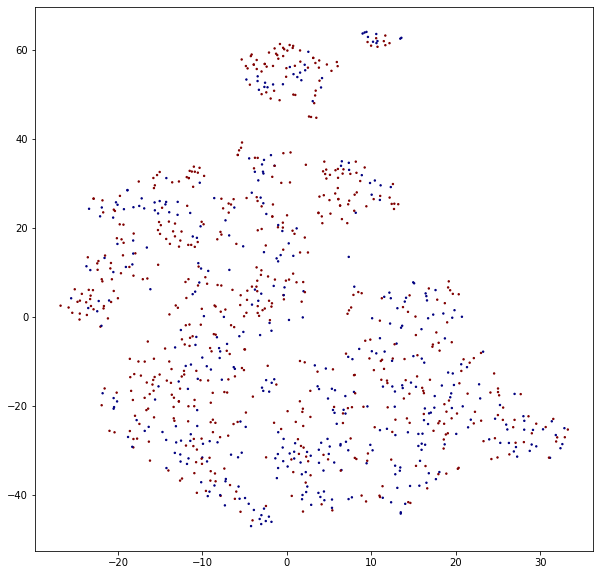

epoch: 1, manual: loss_g: 0.1648 loss_g_ae: 0.1648 loss_g_clas: 6.1908 loss_d: 0.0960 loss_z_clas: 0.5103 accu_d: 0.9680 accu_g: 0.0820 accu_g_gdy: 0.0730 accu_z_clas: 0.7440 bleu: 89.4647 equal: 0.6780 spam: 0.0000 bleu_remain: 68.9382 acc_remain: 0.1536


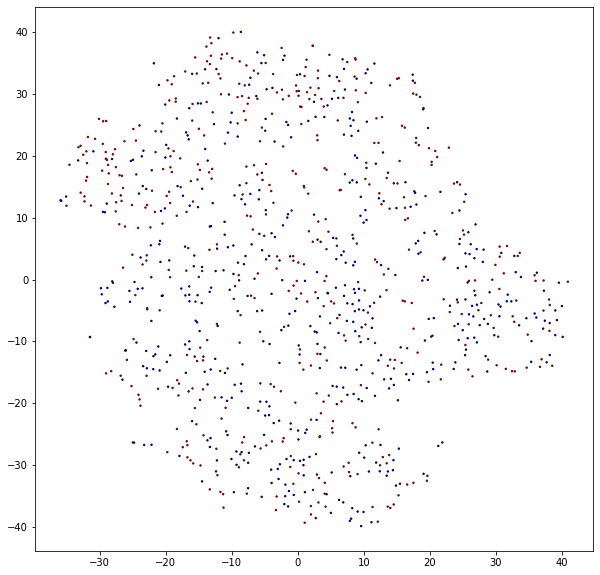

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_ae: 1.0
epoch: 2, step: 1, loss_d: 0.0433 accu_d: 0.9844
epoch: 2, step: 1, loss_z: 0.5957 accu_z: 0.6875
epoch: 2, step: 1, loss_g: 0.3490 loss_g_ae: 0.3490 loss_g_clas: 5.8401 accu_g: 0.0781 accu_g_gdy: 0.0625 accu_z_clas: 0.7969
epoch: 2, step: 500, loss_d: 0.0685 accu_d: 0.9734
epoch: 2, step: 500, loss_z: 0.4982 accu_z: 0.7469
epoch: 2, step: 500, loss_g: 0.2211 loss_g_ae: 0.2211 loss_g_clas: 5.9283 accu_g: 0.1109 accu_g_gdy: 0.1016 accu_z_clas: 0.7750
epoch: 2, step: 1000, loss_d: 0.0808 accu_d: 0.9703
epoch: 2, step: 1000, loss_z: 0.4912 accu_z: 0.7734
epoch: 2, step: 1000, loss_g: 0.2279 loss_g_ae: 0.2279 loss_g_clas: 6.4761 accu_g: 0.0953 accu_g_gdy: 0.0781 accu_z_clas: 0.7891
epoch: 2, step: 1500, loss_d: 0.0493 accu_d: 0.9797
epoch: 2, step: 1500, loss_z: 0.4957 accu_z: 0.7406
epoch: 2, step: 1500, loss_g: 0.1924 loss_g_ae: 0.1924 loss_g_clas: 6.9939 accu_g: 0.0875 accu_g_gdy: 0.0875 accu_z_clas: 0.7891
epoch: 2, step: 2000, l

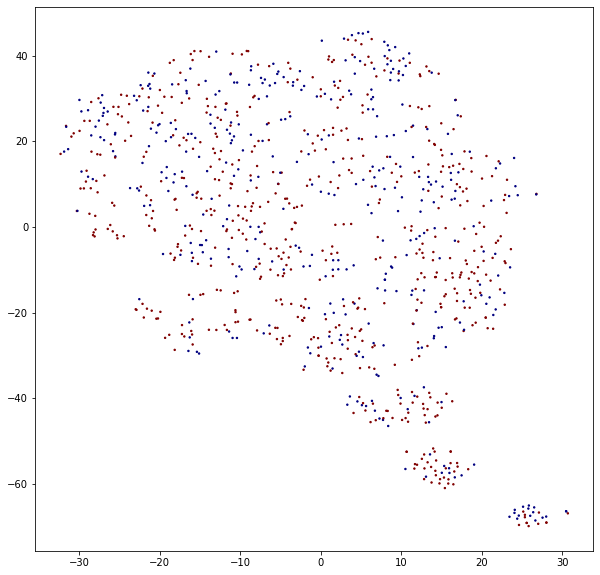

epoch: 2, test: loss_g: 0.0543 loss_g_ae: 0.0543 loss_g_clas: 7.0147 loss_d: 0.0669 loss_z_clas: 0.4572 accu_d: 0.9767 accu_g: 0.0424 accu_g_gdy: 0.0423 accu_z_clas: 0.7820 bleu: 95.0527 equal: 0.8522 spam: 0.0000 bleu_remain: 71.9126 acc_remain: 0.1624


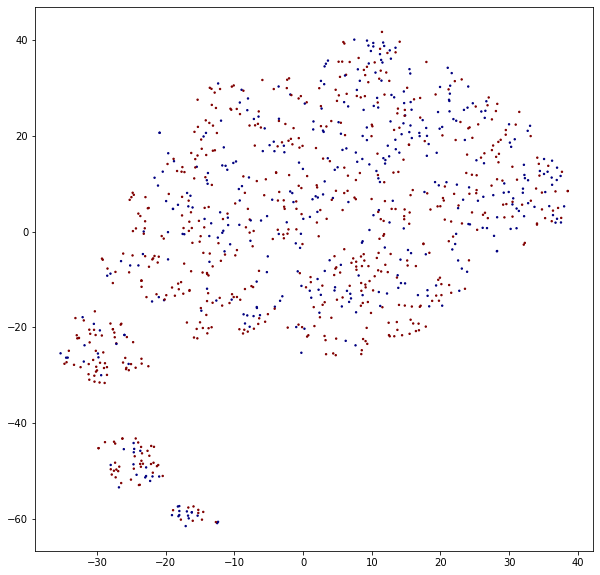

epoch: 2, manual: loss_g: 0.0482 loss_g_ae: 0.0482 loss_g_clas: 6.8238 loss_d: 0.0726 loss_z_clas: 0.5109 accu_d: 0.9750 accu_g: 0.0480 accu_g_gdy: 0.0470 accu_z_clas: 0.7450 bleu: 95.7730 equal: 0.8500 spam: 0.0000 bleu_remain: 71.7628 acc_remain: 0.1560


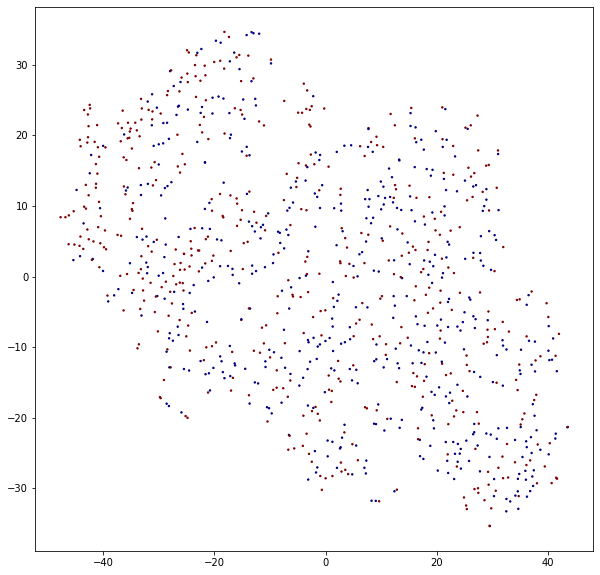

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_ae: 1.0
epoch: 3, step: 1, loss_d: 0.0161 accu_d: 1.0000
epoch: 3, step: 1, loss_z: 0.5170 accu_z: 0.7656
epoch: 3, step: 1, loss_g: 0.0792 loss_g_ae: 0.0792 loss_g_clas: 7.1596 accu_g: 0.0625 accu_g_gdy: 0.0625 accu_z_clas: 0.8594
epoch: 3, step: 500, loss_d: 0.0434 accu_d: 0.9891
epoch: 3, step: 500, loss_z: 0.4361 accu_z: 0.7906
epoch: 3, step: 500, loss_g: 0.0852 loss_g_ae: 0.0852 loss_g_clas: 7.7010 accu_g: 0.0375 accu_g_gdy: 0.0406 accu_z_clas: 0.7875
epoch: 3, step: 1000, loss_d: 0.0555 accu_d: 0.9750
epoch: 3, step: 1000, loss_z: 0.4508 accu_z: 0.7891
epoch: 3, step: 1000, loss_g: 0.0982 loss_g_ae: 0.0982 loss_g_clas: 7.8008 accu_g: 0.0672 accu_g_gdy: 0.0672 accu_z_clas: 0.7453
epoch: 3, step: 1500, loss_d: 0.0444 accu_d: 0.9812
epoch: 3, step: 1500, loss_z: 0.4494 accu_z: 0.7875
epoch: 3, step: 1500, loss_g: 0.1196 loss_g_ae: 0.1196 loss_g_clas: 7.7765 accu_g: 0.0609 accu_g_gdy: 0.0547 accu_z_clas: 0.8172
epoch: 3, step: 2000, l

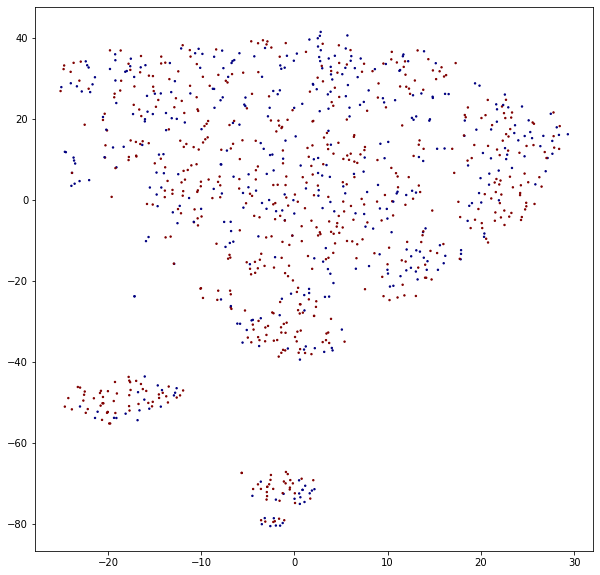

epoch: 3, test: loss_g: 0.0324 loss_g_ae: 0.0324 loss_g_clas: 8.3135 loss_d: 0.0693 loss_z_clas: 0.4375 accu_d: 0.9760 accu_g: 0.0345 accu_g_gdy: 0.0350 accu_z_clas: 0.7954 bleu: 96.9438 equal: 0.9046 spam: 0.0001 bleu_remain: 72.1181 acc_remain: 0.1508


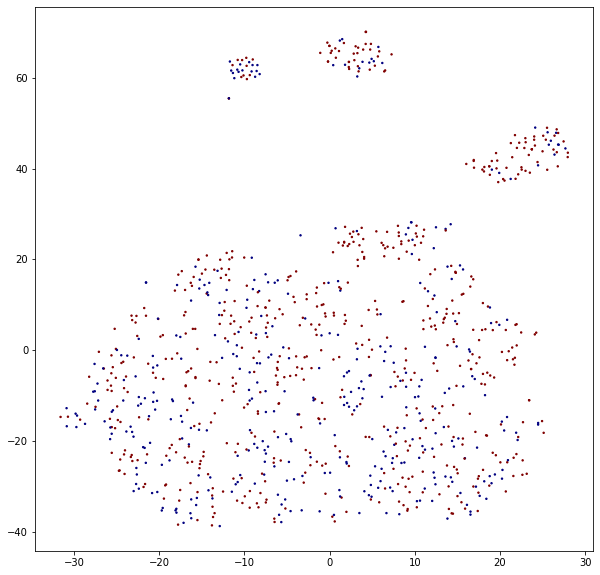

epoch: 3, manual: loss_g: 0.0276 loss_g_ae: 0.0276 loss_g_clas: 8.1454 loss_d: 0.0696 loss_z_clas: 0.5014 accu_d: 0.9730 accu_g: 0.0320 accu_g_gdy: 0.0390 accu_z_clas: 0.7570 bleu: 97.5005 equal: 0.9110 spam: 0.0000 bleu_remain: 71.8724 acc_remain: 0.1456


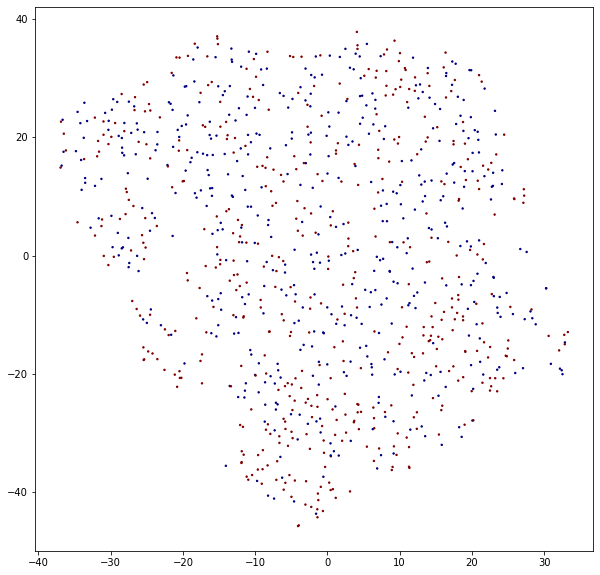

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_ae: 1.0
epoch: 4, step: 1, loss_d: 0.0884 accu_d: 0.9531
epoch: 4, step: 1, loss_z: 0.4113 accu_z: 0.7969
epoch: 4, step: 1, loss_g: 0.0575 loss_g_ae: 0.0575 loss_g_clas: 7.7440 accu_g: 0.0156 accu_g_gdy: 0.0156 accu_z_clas: 0.7969
epoch: 4, step: 500, loss_d: 0.0305 accu_d: 0.9906
epoch: 4, step: 500, loss_z: 0.4570 accu_z: 0.7891
epoch: 4, step: 500, loss_g: 0.0575 loss_g_ae: 0.0575 loss_g_clas: 8.2132 accu_g: 0.0437 accu_g_gdy: 0.0516 accu_z_clas: 0.7984
epoch: 4, step: 1000, loss_d: 0.0672 accu_d: 0.9781
epoch: 4, step: 1000, loss_z: 0.4505 accu_z: 0.7688
epoch: 4, step: 1000, loss_g: 0.0607 loss_g_ae: 0.0607 loss_g_clas: 8.5326 accu_g: 0.0484 accu_g_gdy: 0.0453 accu_z_clas: 0.8000
epoch: 4, step: 1500, loss_d: 0.0425 accu_d: 0.9875
epoch: 4, step: 1500, loss_z: 0.4248 accu_z: 0.7984
epoch: 4, step: 1500, loss_g: 0.0737 loss_g_ae: 0.0737 loss_g_clas: 8.7953 accu_g: 0.0547 accu_g_gdy: 0.0469 accu_z_clas: 0.7766
epoch: 4, step: 2000, l

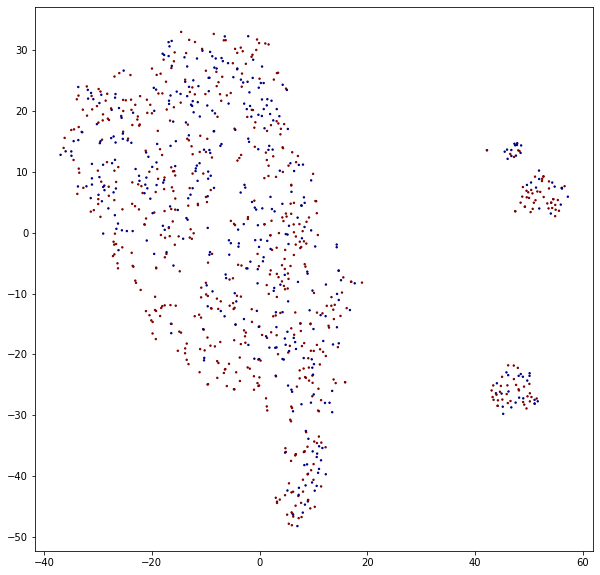

epoch: 4, test: loss_g: 0.0168 loss_g_ae: 0.0168 loss_g_clas: 8.7216 loss_d: 0.0705 loss_z_clas: 0.4335 accu_d: 0.9766 accu_g: 0.0298 accu_g_gdy: 0.0300 accu_z_clas: 0.7979 bleu: 98.2229 equal: 0.9435 spam: 0.0000 bleu_remain: 70.6395 acc_remain: 0.1536


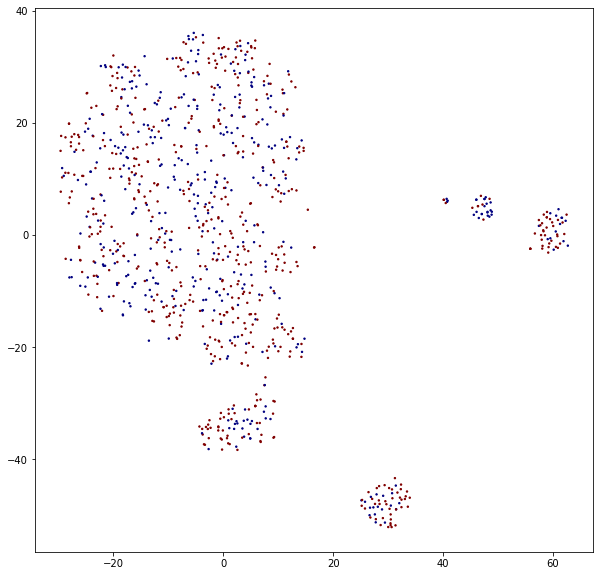

epoch: 4, manual: loss_g: 0.0128 loss_g_ae: 0.0128 loss_g_clas: 8.5967 loss_d: 0.0676 loss_z_clas: 0.4772 accu_d: 0.9790 accu_g: 0.0270 accu_g_gdy: 0.0280 accu_z_clas: 0.7730 bleu: 98.5842 equal: 0.9450 spam: 0.0000 bleu_remain: 69.7454 acc_remain: 0.1787


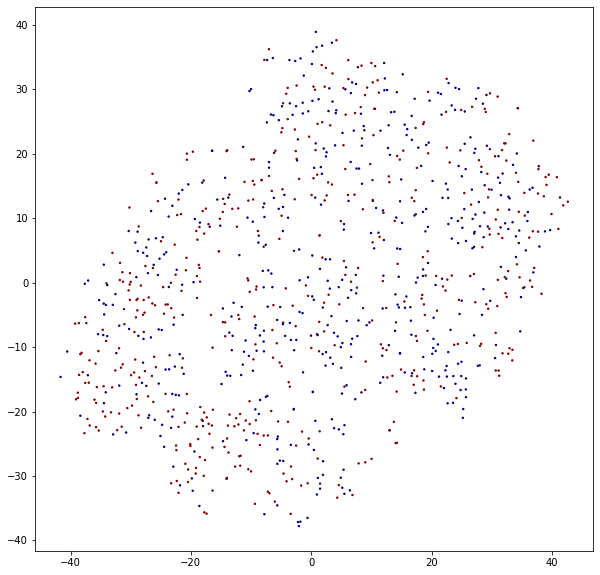

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_ae: 1.0
epoch: 5, step: 1, loss_d: 0.0243 accu_d: 1.0000
epoch: 5, step: 1, loss_z: 0.4213 accu_z: 0.8125
epoch: 5, step: 1, loss_g: 0.0543 loss_g_ae: 0.0543 loss_g_clas: 8.2465 accu_g: 0.0312 accu_g_gdy: 0.0469 accu_z_clas: 0.8438
epoch: 5, step: 1000, loss_d: 0.0500 accu_d: 0.9875
epoch: 5, step: 1000, loss_z: 0.4530 accu_z: 0.7656
epoch: 5, step: 1000, loss_g: 0.0412 loss_g_ae: 0.0412 loss_g_clas: 9.5188 accu_g: 0.0172 accu_g_gdy: 0.0203 accu_z_clas: 0.7844
epoch: 5, step: 1500, loss_d: 0.0283 accu_d: 0.9844
epoch: 5, step: 1500, loss_z: 0.4358 accu_z: 0.7922
epoch: 5, step: 1500, loss_g: 0.0430 loss_g_ae: 0.0430 loss_g_clas: 9.2848 accu_g: 0.0375 accu_g_gdy: 0.0344 accu_z_clas: 0.7891
epoch: 5, step: 2000, loss_d: 0.0152 accu_d: 0.9969
epoch: 5, step: 2000, loss_z: 0.4334 accu_z: 0.8000
epoch: 5, step: 2000, loss_g: 0.0419 loss_g_ae: 0.0419 loss_g_clas: 9.8383 accu_g: 0.0266 accu_g_gdy: 0.0312 accu_z_clas: 0.7719
epoch: 5, step: 2500

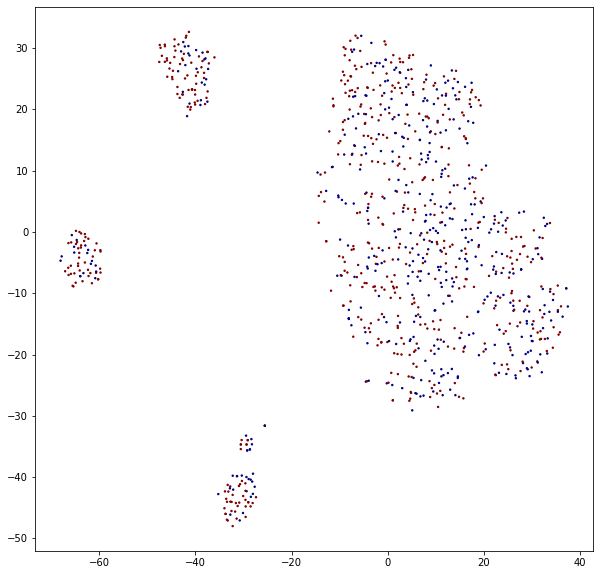

epoch: 5, test: loss_g: 0.0099 loss_g_ae: 0.0099 loss_g_clas: 9.5112 loss_d: 0.0772 loss_z_clas: 0.4167 accu_d: 0.9746 accu_g: 0.0280 accu_g_gdy: 0.0285 accu_z_clas: 0.8074 bleu: 99.0640 equal: 0.9696 spam: 0.0001 bleu_remain: 60.6012 acc_remain: 0.1240


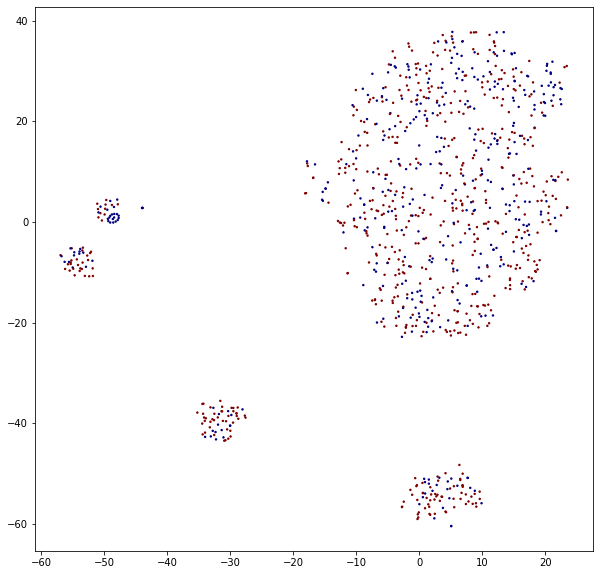

epoch: 5, manual: loss_g: 0.0069 loss_g_ae: 0.0069 loss_g_clas: 9.5576 loss_d: 0.0682 loss_z_clas: 0.4697 accu_d: 0.9770 accu_g: 0.0280 accu_g_gdy: 0.0280 accu_z_clas: 0.7810 bleu: 99.2279 equal: 0.9690 spam: 0.0000 bleu_remain: 62.3228 acc_remain: 0.1936


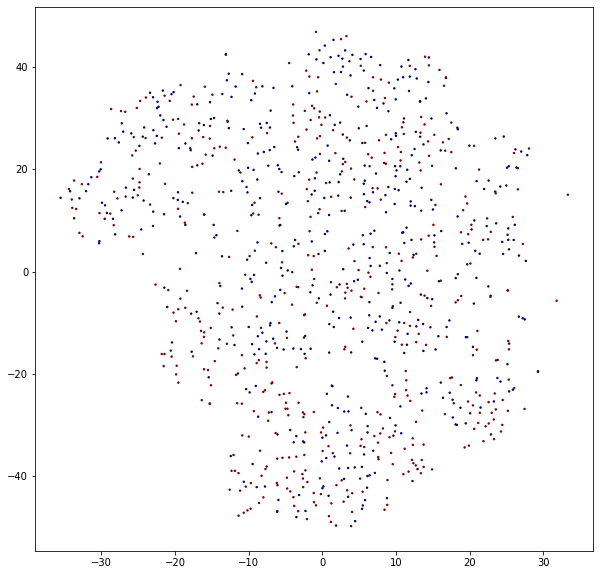

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_ae: 1.0
epoch: 6, step: 1, loss_d: 0.0837 accu_d: 0.9688
epoch: 6, step: 1, loss_z: 0.3968 accu_z: 0.7969
epoch: 6, step: 1, loss_g: 0.1289 loss_g_ae: 0.1289 loss_g_clas: 10.5749 accu_g: 0.0156 accu_g_gdy: 0.0156 accu_z_clas: 0.8594
epoch: 6, step: 500, loss_d: 0.0213 accu_d: 0.9922
epoch: 6, step: 500, loss_z: 0.4388 accu_z: 0.8109
epoch: 6, step: 500, loss_g: 0.0237 loss_g_ae: 0.0237 loss_g_clas: 10.2727 accu_g: 0.0266 accu_g_gdy: 0.0187 accu_z_clas: 0.7859
epoch: 6, step: 1000, loss_d: 0.0204 accu_d: 0.9922
epoch: 6, step: 1000, loss_z: 0.4390 accu_z: 0.8031
epoch: 6, step: 1000, loss_g: 0.0287 loss_g_ae: 0.0287 loss_g_clas: 11.6956 accu_g: 0.0141 accu_g_gdy: 0.0219 accu_z_clas: 0.7906
epoch: 6, step: 1500, loss_d: 0.0216 accu_d: 0.9953
epoch: 6, step: 1500, loss_z: 0.4540 accu_z: 0.7906
epoch: 6, step: 1500, loss_g: 0.0194 loss_g_ae: 0.0194 loss_g_clas: 10.6879 accu_g: 0.0359 accu_g_gdy: 0.0391 accu_z_clas: 0.7734
epoch: 6, step: 200

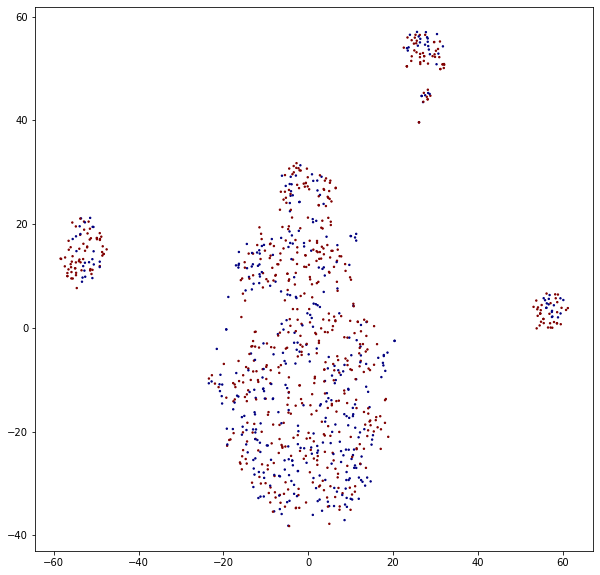

epoch: 6, test: loss_g: 0.0048 loss_g_ae: 0.0048 loss_g_clas: 10.7276 loss_d: 0.0793 loss_z_clas: 0.4032 accu_d: 0.9754 accu_g: 0.0264 accu_g_gdy: 0.0265 accu_z_clas: 0.8136 bleu: 99.4676 equal: 0.9824 spam: 0.0000 bleu_remain: 47.1133 acc_remain: 0.0983


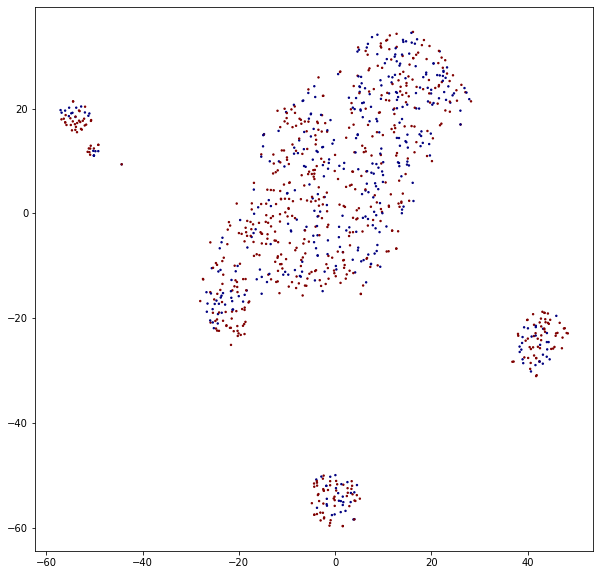

epoch: 6, manual: loss_g: 0.0055 loss_g_ae: 0.0055 loss_g_clas: 10.5241 loss_d: 0.0750 loss_z_clas: 0.4766 accu_d: 0.9770 accu_g: 0.0270 accu_g_gdy: 0.0260 accu_z_clas: 0.7760 bleu: 99.4452 equal: 0.9770 spam: 0.0000 bleu_remain: 63.3120 acc_remain: 0.1573


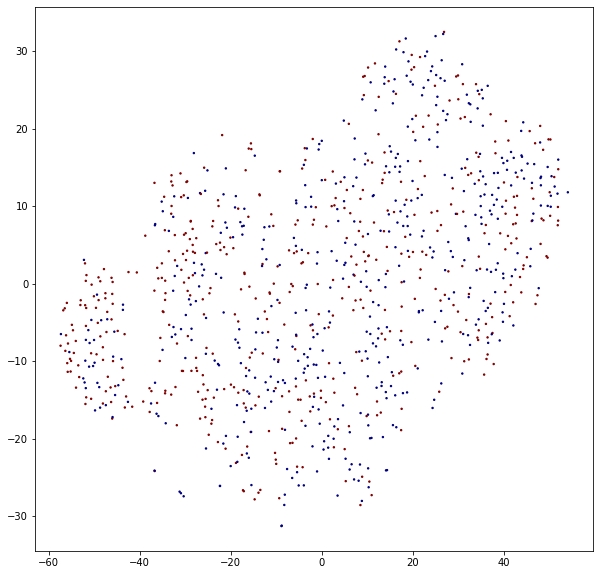

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_ae: 1.0
epoch: 7, step: 1, loss_d: 0.0093 accu_d: 1.0000
epoch: 7, step: 1, loss_z: 0.5282 accu_z: 0.7656
epoch: 7, step: 1, loss_g: 0.0020 loss_g_ae: 0.0020 loss_g_clas: 11.3656 accu_g: 0.0000 accu_g_gdy: 0.0000 accu_z_clas: 0.8594
epoch: 7, step: 500, loss_d: 0.0092 accu_d: 0.9969
epoch: 7, step: 500, loss_z: 0.4186 accu_z: 0.8203
epoch: 7, step: 500, loss_g: 0.0254 loss_g_ae: 0.0254 loss_g_clas: 10.9852 accu_g: 0.0094 accu_g_gdy: 0.0125 accu_z_clas: 0.7875
epoch: 7, step: 1000, loss_d: 0.0155 accu_d: 0.9953
epoch: 7, step: 1000, loss_z: 0.4454 accu_z: 0.7797
epoch: 7, step: 1000, loss_g: 0.0167 loss_g_ae: 0.0167 loss_g_clas: 11.7530 accu_g: 0.0094 accu_g_gdy: 0.0125 accu_z_clas: 0.7766
epoch: 7, step: 1500, loss_d: 0.0136 accu_d: 0.9953
epoch: 7, step: 1500, loss_z: 0.4236 accu_z: 0.7969
epoch: 7, step: 1500, loss_g: 0.0203 loss_g_ae: 0.0203 loss_g_clas: 11.5546 accu_g: 0.0266 accu_g_gdy: 0.0266 accu_z_clas: 0.8297
epoch: 7, step: 200

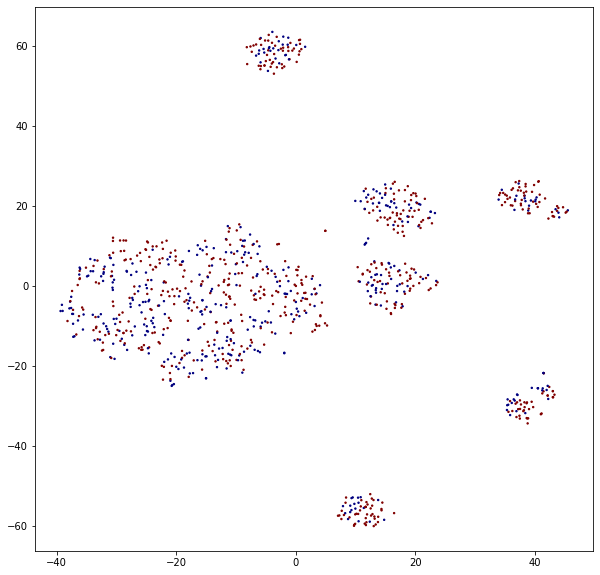

epoch: 7, test: loss_g: 0.0029 loss_g_ae: 0.0029 loss_g_clas: 12.1023 loss_d: 0.0885 loss_z_clas: 0.3975 accu_d: 0.9746 accu_g: 0.0263 accu_g_gdy: 0.0265 accu_z_clas: 0.8184 bleu: 99.6748 equal: 0.9890 spam: 0.0000 bleu_remain: 36.2664 acc_remain: 0.0755


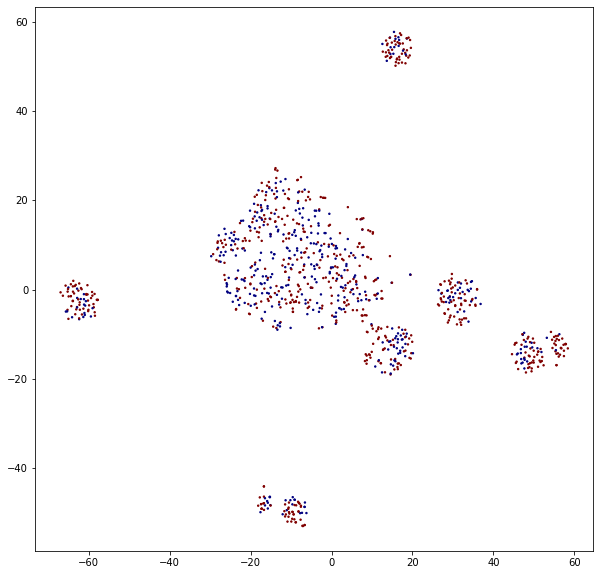

epoch: 7, manual: loss_g: 0.0016 loss_g_ae: 0.0016 loss_g_clas: 12.2505 loss_d: 0.0734 loss_z_clas: 0.4606 accu_d: 0.9810 accu_g: 0.0220 accu_g_gdy: 0.0200 accu_z_clas: 0.7760 bleu: 99.8400 equal: 0.9940 spam: 0.0000 bleu_remain: 20.9658 acc_remain: 0.0640


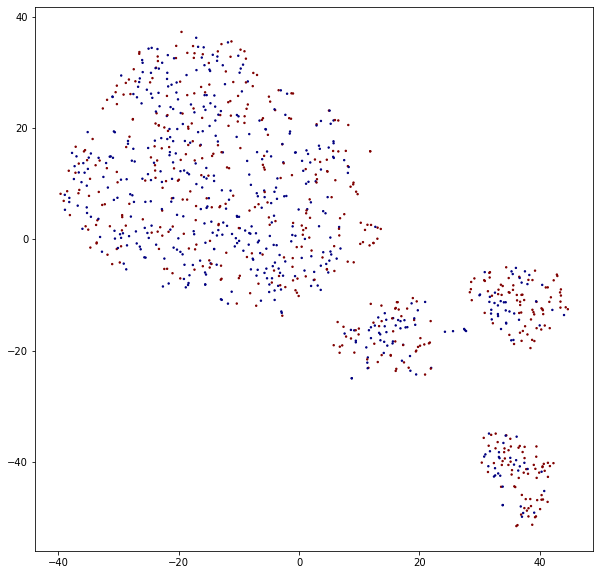

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_ae: 1.0
epoch: 8, step: 1, loss_d: 0.0456 accu_d: 0.9844
epoch: 8, step: 1, loss_z: 0.3784 accu_z: 0.8438
epoch: 8, step: 1, loss_g: 0.0115 loss_g_ae: 0.0115 loss_g_clas: 13.0941 accu_g: 0.0312 accu_g_gdy: 0.0000 accu_z_clas: 0.8125
epoch: 8, step: 500, loss_d: 0.0200 accu_d: 0.9938
epoch: 8, step: 500, loss_z: 0.4504 accu_z: 0.7953
epoch: 8, step: 500, loss_g: 0.0363 loss_g_ae: 0.0363 loss_g_clas: 12.4456 accu_g: 0.0141 accu_g_gdy: 0.0109 accu_z_clas: 0.7828
epoch: 8, step: 1000, loss_d: 0.0130 accu_d: 0.9953
epoch: 8, step: 1000, loss_z: 0.4188 accu_z: 0.8125
epoch: 8, step: 1000, loss_g: 0.0124 loss_g_ae: 0.0124 loss_g_clas: 12.2489 accu_g: 0.0125 accu_g_gdy: 0.0109 accu_z_clas: 0.7672
epoch: 8, step: 1500, loss_d: 0.0144 accu_d: 0.9938
epoch: 8, step: 1500, loss_z: 0.4080 accu_z: 0.8000
epoch: 8, step: 1500, loss_g: 0.0145 loss_g_ae: 0.0145 loss_g_clas: 12.8767 accu_g: 0.0109 accu_g_gdy: 0.0187 accu_z_clas: 0.7984
epoch: 8, step: 200

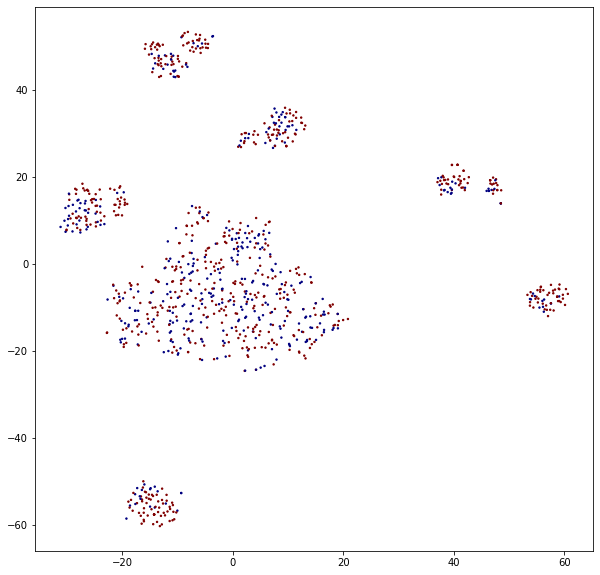

epoch: 8, test: loss_g: 0.0021 loss_g_ae: 0.0021 loss_g_clas: 12.5624 loss_d: 0.0947 loss_z_clas: 0.4007 accu_d: 0.9732 accu_g: 0.0274 accu_g_gdy: 0.0275 accu_z_clas: 0.8137 bleu: 99.7520 equal: 0.9917 spam: 0.0000 bleu_remain: 28.3392 acc_remain: 0.0498


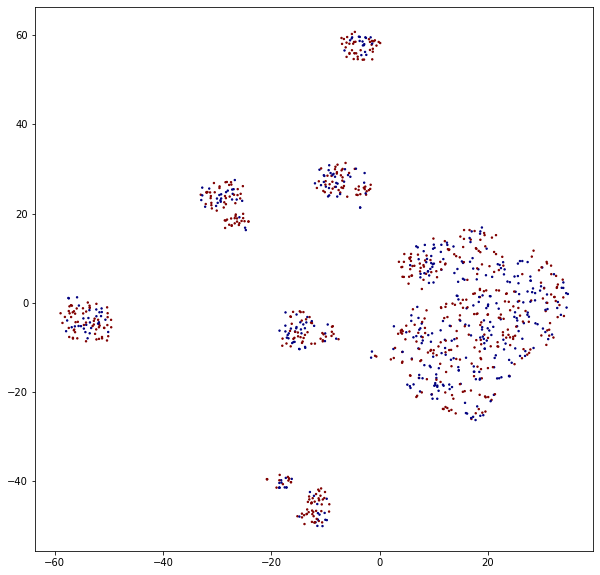

epoch: 8, manual: loss_g: 0.0013 loss_g_ae: 0.0013 loss_g_clas: 12.6964 loss_d: 0.0861 loss_z_clas: 0.4645 accu_d: 0.9760 accu_g: 0.0250 accu_g_gdy: 0.0250 accu_z_clas: 0.7650 bleu: 99.8086 equal: 0.9920 spam: 0.0000 bleu_remain: 28.5344 acc_remain: 0.0640


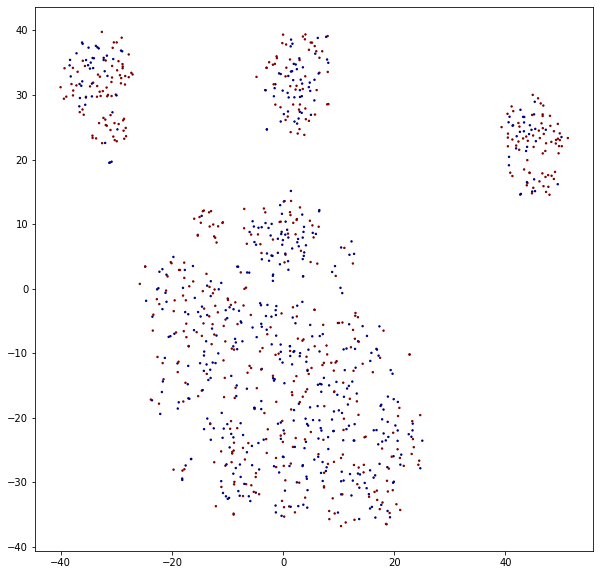

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_ae: 1.0
epoch: 9, step: 1, loss_d: 0.0523 accu_d: 0.9844
epoch: 9, step: 1, loss_z: 0.4185 accu_z: 0.7969
epoch: 9, step: 1, loss_g: 0.0081 loss_g_ae: 0.0081 loss_g_clas: 12.5962 accu_g: 0.0312 accu_g_gdy: 0.0156 accu_z_clas: 0.8281
epoch: 9, step: 500, loss_d: 0.0200 accu_d: 0.9906
epoch: 9, step: 500, loss_z: 0.4061 accu_z: 0.8125
epoch: 9, step: 500, loss_g: 0.0167 loss_g_ae: 0.0167 loss_g_clas: 13.8049 accu_g: 0.0172 accu_g_gdy: 0.0156 accu_z_clas: 0.8281
epoch: 9, step: 1000, loss_d: 0.0137 accu_d: 0.9969
epoch: 9, step: 1000, loss_z: 0.4414 accu_z: 0.7844
epoch: 9, step: 1000, loss_g: 0.0137 loss_g_ae: 0.0137 loss_g_clas: 13.7853 accu_g: 0.0094 accu_g_gdy: 0.0109 accu_z_clas: 0.8031
epoch: 9, step: 1500, loss_d: 0.0134 accu_d: 0.9938
epoch: 9, step: 1500, loss_z: 0.4236 accu_z: 0.8109
epoch: 9, step: 1500, loss_g: 0.0097 loss_g_ae: 0.0097 loss_g_clas: 13.8086 accu_g: 0.0156 accu_g_gdy: 0.0125 accu_z_clas: 0.7906
epoch: 9, step: 200

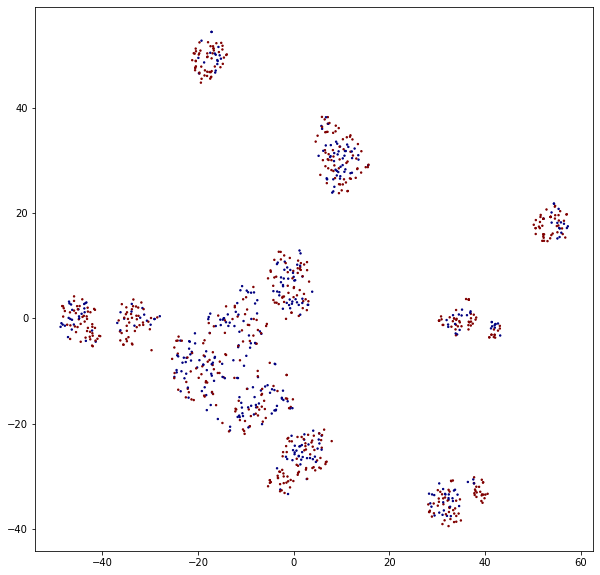

epoch: 9, test: loss_g: 0.0012 loss_g_ae: 0.0012 loss_g_clas: 13.8971 loss_d: 0.0992 loss_z_clas: 0.3887 accu_d: 0.9741 accu_g: 0.0262 accu_g_gdy: 0.0264 accu_z_clas: 0.8207 bleu: 99.8609 equal: 0.9953 spam: 0.0000 bleu_remain: 18.1959 acc_remain: 0.0369


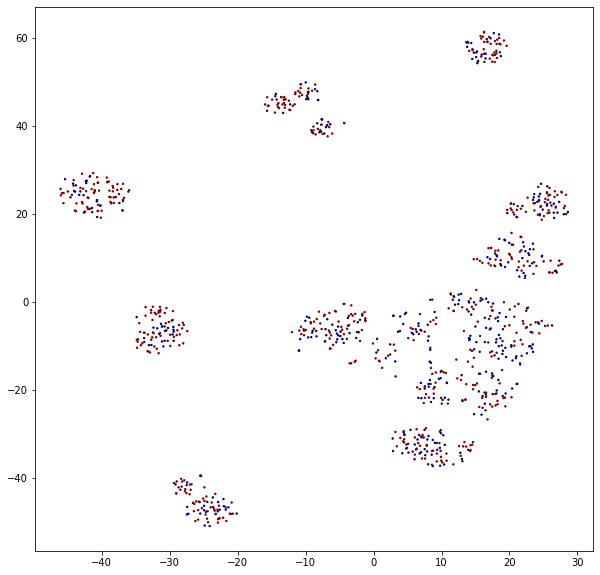

epoch: 9, manual: loss_g: 0.0004 loss_g_ae: 0.0004 loss_g_clas: 13.9144 loss_d: 0.0896 loss_z_clas: 0.4638 accu_d: 0.9740 accu_g: 0.0260 accu_g_gdy: 0.0260 accu_z_clas: 0.7800 bleu: 99.9718 equal: 0.9990 spam: 0.0000 bleu_remain: 5.1654 acc_remain: 0.0000


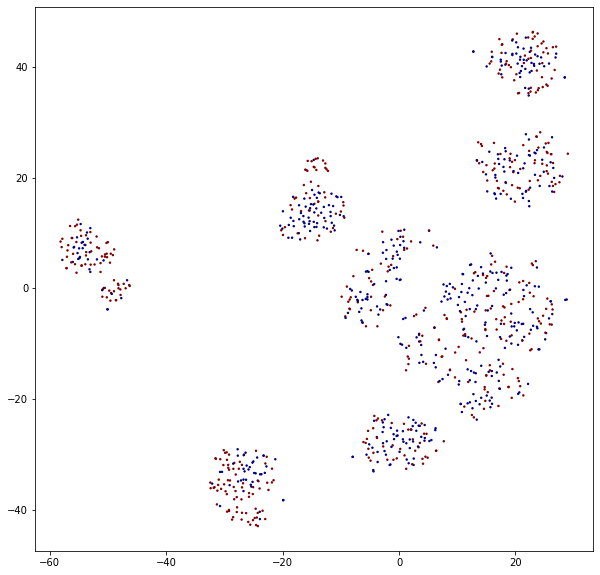

gamma: 1.0, lambda_g: 0.0, lambda_z: 0.0, lambda_ae: 1.0
epoch: 10, step: 1, loss_d: 0.0145 accu_d: 1.0000
epoch: 10, step: 1, loss_z: 0.4819 accu_z: 0.7812
epoch: 10, step: 1, loss_g: 0.0086 loss_g_ae: 0.0086 loss_g_clas: 13.5201 accu_g: 0.0156 accu_g_gdy: 0.0156 accu_z_clas: 0.7969
epoch: 10, step: 500, loss_d: 0.0125 accu_d: 0.9953
epoch: 10, step: 500, loss_z: 0.4332 accu_z: 0.7969
epoch: 10, step: 500, loss_g: 0.0080 loss_g_ae: 0.0080 loss_g_clas: 14.4779 accu_g: 0.0047 accu_g_gdy: 0.0063 accu_z_clas: 0.8328
epoch: 10, step: 1000, loss_d: 0.0201 accu_d: 0.9938
epoch: 10, step: 1000, loss_z: 0.3956 accu_z: 0.8141
epoch: 10, step: 1000, loss_g: 0.0094 loss_g_ae: 0.0094 loss_g_clas: 14.7106 accu_g: 0.0141 accu_g_gdy: 0.0187 accu_z_clas: 0.8016
epoch: 10, step: 1500, loss_d: 0.0094 accu_d: 0.9969
epoch: 10, step: 1500, loss_z: 0.4378 accu_z: 0.7750
epoch: 10, step: 1500, loss_g: 0.0098 loss_g_ae: 0.0098 loss_g_clas: 14.7371 accu_g: 0.0063 accu_g_gdy: 0.0094 accu_z_clas: 0.8187
epoch: 

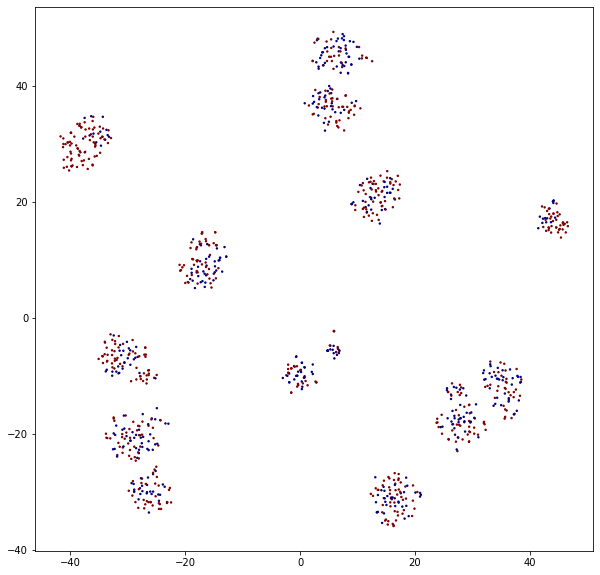

epoch: 10, test: loss_g: 0.0008 loss_g_ae: 0.0008 loss_g_clas: 14.7487 loss_d: 0.1048 loss_z_clas: 0.3890 accu_d: 0.9738 accu_g: 0.0265 accu_g_gdy: 0.0265 accu_z_clas: 0.8220 bleu: 99.9027 equal: 0.9966 spam: 0.0000 bleu_remain: 12.2910 acc_remain: 0.0259


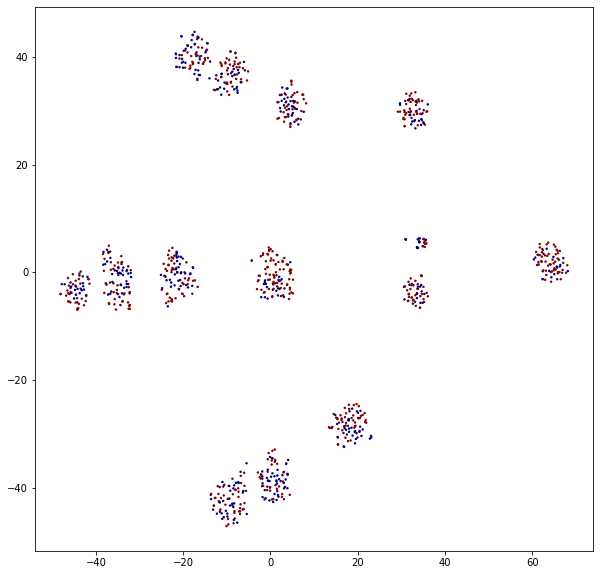

epoch: 10, manual: loss_g: 0.0014 loss_g_ae: 0.0014 loss_g_clas: 14.8512 loss_d: 0.0861 loss_z_clas: 0.4397 accu_d: 0.9750 accu_g: 0.0250 accu_g_gdy: 0.0250 accu_z_clas: 0.7850 bleu: 99.8970 equal: 0.9960 spam: 0.0000 bleu_remain: 20.4410 acc_remain: 0.0000


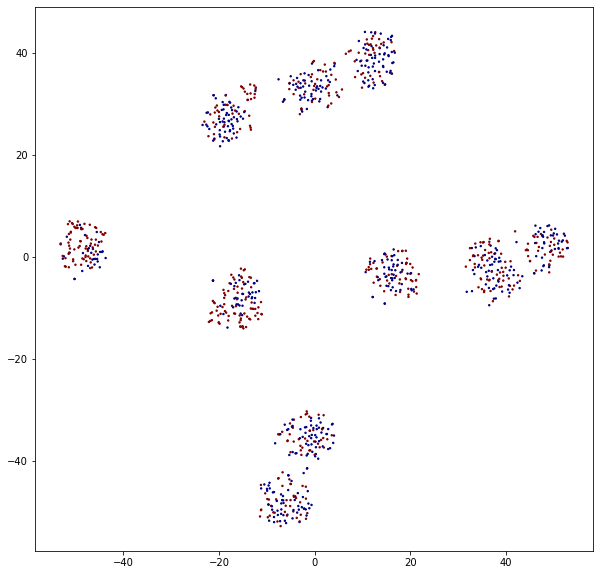

gamma: 0.5, lambda_g: 0.1, lambda_z: 0.5, lambda_ae: 1.0
epoch: 11, step: 1, loss_d: 0.0021 accu_d: 1.0000
epoch: 11, step: 1, loss_z: 0.4794 accu_z: 0.8125
epoch: 11, step: 1, loss_g: 1.1396 loss_g_ae: 0.0011 loss_g_clas: 14.0322 accu_g: 0.0312 accu_g_gdy: 0.0469 accu_z_clas: 0.7656
epoch: 11, step: 500, loss_d: 0.0127 accu_d: 0.9969
epoch: 11, step: 500, loss_z: 0.6941 accu_z: 0.6016
epoch: 11, step: 500, loss_g: 0.0413 loss_g_ae: 0.2522 loss_g_clas: 1.3868 accu_g: 0.7812 accu_g_gdy: 0.7750 accu_z_clas: 0.5922
epoch: 11, step: 1000, loss_d: 0.0058 accu_d: 1.0000
epoch: 11, step: 1000, loss_z: 0.6136 accu_z: 0.6797
epoch: 11, step: 1000, loss_g: -0.0152 loss_g_ae: 0.1604 loss_g_clas: 1.3038 accu_g: 0.8172 accu_g_gdy: 0.8172 accu_z_clas: 0.6797
epoch: 11, step: 1500, loss_d: 0.0080 accu_d: 1.0000
epoch: 11, step: 1500, loss_z: 0.5552 accu_z: 0.7375
epoch: 11, step: 1500, loss_g: -0.0146 loss_g_ae: 0.1295 loss_g_clas: 1.2087 accu_g: 0.8203 accu_g_gdy: 0.8156 accu_z_clas: 0.7422
epoch: 1

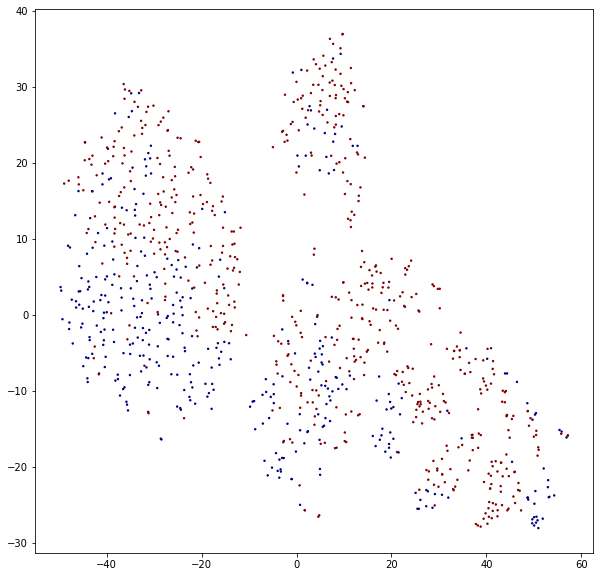

epoch: 11, test: loss_g: -0.2400 loss_g_ae: 0.0279 loss_g_clas: 0.6789 loss_d: 0.1137 loss_z_clas: 0.6716 accu_d: 0.9723 accu_g: 0.8844 accu_g_gdy: 0.8818 accu_z_clas: 0.5971 bleu: 63.5659 equal: 0.1060 spam: 0.0004 bleu_remain: 58.5548 acc_remain: 0.9659


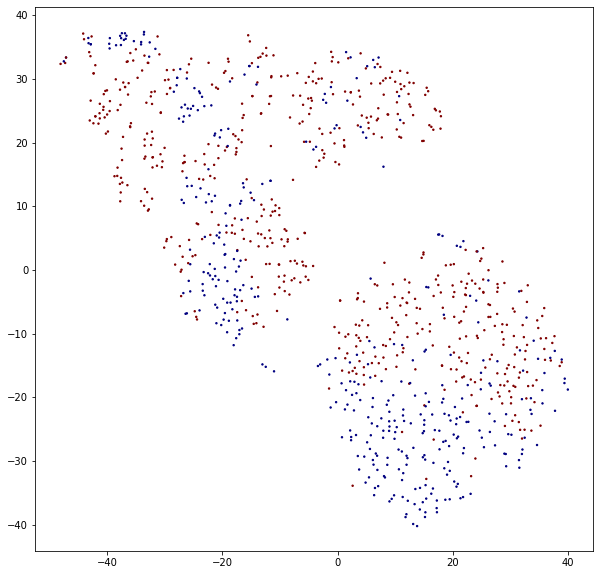

epoch: 12, step: 1000, loss_d: 0.0043 accu_d: 1.0000
epoch: 12, step: 1000, loss_z: 0.6742 accu_z: 0.5922
epoch: 12, step: 1000, loss_g: -0.2044 loss_g_ae: 0.0630 loss_g_clas: 0.6482 accu_g: 0.9016 accu_g_gdy: 0.9094 accu_z_clas: 0.6141
epoch: 12, step: 1500, loss_d: 0.0173 accu_d: 0.9984
epoch: 12, step: 1500, loss_z: 0.6717 accu_z: 0.5891
epoch: 12, step: 1500, loss_g: -0.1878 loss_g_ae: 0.0987 loss_g_clas: 0.5312 accu_g: 0.9187 accu_g_gdy: 0.9078 accu_z_clas: 0.5734
epoch: 12, step: 2000, loss_d: 0.0107 accu_d: 0.9953
epoch: 12, step: 2000, loss_z: 0.6309 accu_z: 0.6500
epoch: 12, step: 2000, loss_g: -0.2002 loss_g_ae: 0.0823 loss_g_clas: 0.4420 accu_g: 0.9281 accu_g_gdy: 0.9266 accu_z_clas: 0.6062
epoch: 12, step: 2500, loss_d: 0.0159 accu_d: 0.9906
epoch: 12, step: 2500, loss_z: 0.6783 accu_z: 0.6266
epoch: 12, step: 2500, loss_g: -0.1879 loss_g_ae: 0.0961 loss_g_clas: 0.5994 accu_g: 0.9000 accu_g_gdy: 0.8984 accu_z_clas: 0.5984
epoch: 12, step: 3000, loss_d: 0.0207 accu_d: 0.9938

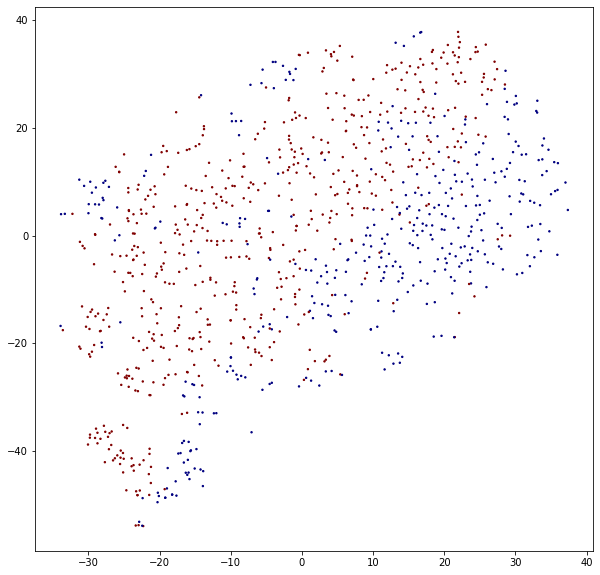

epoch: 12, manual: loss_g: -0.2620 loss_g_ae: 0.0251 loss_g_clas: 0.7817 loss_d: 0.1054 loss_z_clas: 0.7306 accu_d: 0.9740 accu_g: 0.8750 accu_g_gdy: 0.8670 accu_z_clas: 0.4930 bleu: 66.3137 equal: 0.1130 spam: 0.0010 bleu_remain: 61.3994 acc_remain: 0.9603


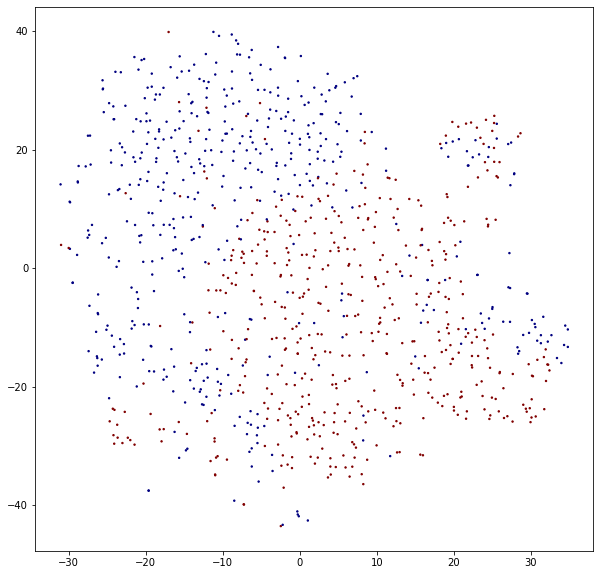

In [6]:
train_model()

In [19]:
print_result()

[['Input Sentence', 'Input Label', 'Generated Sentence', 'Predicted Label', 'BLEU'], ['i was so scared and they made me feel very at ease .', 1, 'i was so scared and they made me feel very at zero .', 0, 0.842362674378975], ['the owners are fair and honest , helpful and efficient .', 1, 'the owners are sadly and lacking , helpful and efficient .', 0, 0.4832697830906221], ['it had zero flavor period .', 0, 'it had ease flavor period .', 1, 0.7008534286706599], ['sushi happy hour is the hidden secret .', 1, 'sushi noisy hour is the worst secret .', 0, 0.4905457530262492], ['we were beyond pleased with the taste and quality of the bagels !', 1, 'we were beyond avoid with the taste and lacking of the bagels !', 0, 0.4758733096412523], ["server again disappeared in between my husband 's plate being removed and my finishing .", 0, "server again matthew in between my husband 's plate being throughly and my loves .", 1, 0.4920274515385508], ['would recommend to anyone .', 1, 'would allergic to